<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/driver_action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Authorize Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#download train and test images
download = drive.CreateFile({'id': '1KPoJecKIQCufzJo-LANkySjF8rp4motV'})
download.GetContentFile('driver-detection-train-data.zip')

download = drive.CreateFile({'id': '1POWy7luJLkVWEo5Iq0Dkgj1EbGn81-RQ'})
download.GetContentFile('driver-detection-test-data.zip')

#Extract files
zip_ref = zipfile.ZipFile('driver-detection-train-data.zip', 'r')
zip_ref.extractall('tmp/trains')
import fnmatch

##Not sure why it cannot detect the file
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*test*.zip'):
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall('tmp/test')

zip_ref.close()

In [7]:
from keras.utils import to_categorical

def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

TRAINING_DIR = 'tmp/trains/driver-detection-train-data'
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

files = []
categories = []
paths = []

for i in range(10):
  for file in os.listdir("%s/c%s" %(TRAINING_DIR, i)):
    files.append(file)
    categories.append(i)
    paths.append("%s/c%s/%s" %(TRAINING_DIR, i, file))

df = pd.DataFrame({'file': files,
                   'category': categories,
                   'path': paths
                  })

df['Y'] = df['category'].map(lambda x: to_categorical(x, 10, dtype='uint8'))
df['X'] = df['path'].map(lambda path: get_im_cv2(path, IMAGE_WIDTH, IMAGE_HEIGHT))
df.sample(5, axis=None)

,file,category,path,Y,X
19151,img_4823.jpg,8,tmp/trains/driver-detection-train-data/c8/img_...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[[[20, 25, 23], [20, 25, 23], [20, 26, 22], [2..."
14124,img_555.jpg,6,tmp/trains/driver-detection-train-data/c6/img_...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[[[44, 53, 40], [44, 53, 40], [44, 53, 40], [4..."
19168,img_32089.jpg,8,tmp/trains/driver-detection-train-data/c8/img_...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[[[41, 50, 37], [41, 49, 38], [41, 49, 39], [4..."
4517,img_19727.jpg,1,tmp/trains/driver-detection-train-data/c1/img_...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[[[43, 52, 39], [43, 52, 39], [43, 52, 39], [4..."
15230,img_77417.jpg,6,tmp/trains/driver-detection-train-data/c6/img_...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[[[45, 52, 45], [45, 52, 45], [45, 52, 45], [4..."


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

In [11]:
#build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 

for layer in base_model.layers:
    layer.trainable = False

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

## Train
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=5
BATCH_SIZE=15
callbacks = [learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    ,callbacks=callbacks)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_101 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_152 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)              

In [0]:
index=9
TEST_DIRECTORY = 'tmp/test/driver-detection-test-data/batch' + str(index)
test_data = pd.DataFrame({'filename': os.listdir(TEST_DIRECTORY)})

#test_data_frame = test_data.sample(20, axis=None)
test_data['X'] = test_data['filename'].map(lambda file: get_im_cv2(TEST_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

x_perf=[]
for item in test_data['X']:
  x_perf.append(item)

x_perf = np.array(x_perf, dtype=np.uint8)
predict_df = model.predict(x_perf)


In [0]:
#Copy prediction file to G-drive
import shutil
CATEGORY_PATH='tmp/predict' + str(index)
#shutil.rmtree(CATEGORY_PATH)
#print(test_data.head())
if not os.path.exists(CATEGORY_PATH):
  os.mkdir(CATEGORY_PATH)
  for i in range(10):
    os.mkdir("%s/c%s"% (CATEGORY_PATH,str(i)))

test_data['category'] = np.argmax(predict_df, axis=1)
for _, row in test_data.iterrows():
  #print(row['category'])
  #print(str(row['category']))
  shutil.copyfile(TEST_DIRECTORY + "/" + row['filename'], CATEGORY_PATH + "/" + 'c' + str(row['category']) + "/" + row['filename'])

ZIP_FILE_NAME='predict' + str(index)
shutil.make_archive(ZIP_FILE_NAME, 'zip', CATEGORY_PATH + '/c' + str(index))
shutil.copyfile(ZIP_FILE_NAME +'.zip','/content/drive/My Drive/colab/' + ZIP_FILE_NAME + '.zip')

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


           filename  ...           action
2831  img_46025.jpg  ...  texting - right
5640  img_42614.jpg  ...  reaching behind
3297  img_45917.jpg  ...  reaching behind
1082  img_48251.jpg  ...  reaching behind
5599  img_48841.jpg  ...  reaching behind

[5 rows x 4 columns]


ValueError: ignored

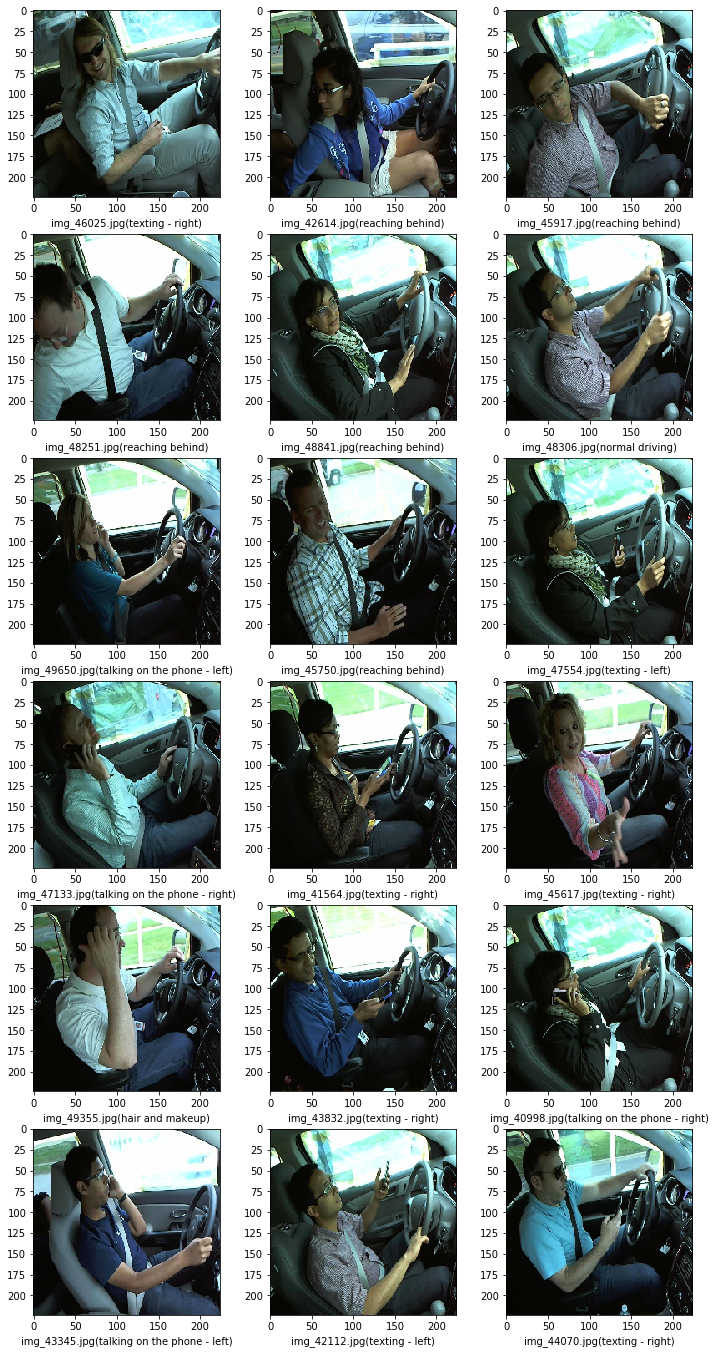

In [14]:
#Plot prediction
import matplotlib.pyplot as plt
label_map = {
    0: "normal driving",
    1: "texting - right",
    2: "talking on the phone - right",
    3: "texting - left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}

test_data_frame['category'] = np.argmax(predict, axis=1)
test_data_frame['action'] = test_data_frame['category'].map(lambda x: label_map.get(x))
print(test_data_frame.head())

#Draw predictions with images
from keras.preprocessing.image import load_img
sample_test = test_data_frame
plt.figure(figsize=(12, 24))
index=0
for _, row in sample_test.iterrows():
    filename = row['filename']
    category = row['action']
    index=index+1
    img = load_img(TEST_DIRECTORY+"/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()